[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/PepeLira/car_trajectory_extractor/blob/main/video_stabilizer/Parte1_Alineamiento_de_Fotogramas_José_Lira.ipynb)

# 1. Demostración Alineamiento de Fotogramas

Este Colab busca estudiar metodologías con el objetivo de alinear los frames de videos y presentar un cuadro estático sin cambios significativos en la posición de la cámara o los objetos en la escena. Para este analisis se presume que los movimientos pueden ser modeladas como una transformación afín, permitiendo 4 grados de livertad,
dentro de las que se incluyen desplazamientos, rotaciones y escalamiento.

El procedimiento planteado consta de las siguientes etapas:

1. Extracción de Fotogramas de video
2. Selección de Fotogramas de Referencia
3. Alineamiento de Fotogramas


Para poder realizar esta tarea se plantean los siguientes pasos:

1. Extracción de Características de cada imagen: para esto se utiliza el algoritmo ORB (Oriented FAST and Rotated BRIEF) disponible en la librería OpenCV.
2. Comparar y Emparejar características entre pares de frames: para esto utilizamos el algoritmo BFmatcher el cual usando "fuerza bruta" (comparando cada descriptor uno a uno) obtiene la distancia entre cada descriptor mediante hamming dado que los descriptores son binarios.
3. Filtrar las Parejas de características: con el objetivo de estudiar cuantas características son necesarias para cumplir con el objetivo.
4. Extraer los key points de cada descriptor
5. Calcular la matriz de transformación afín, para cada característica (keypoint + descriptor).
6. Ponderar la matriz con el frame de la secuencia para alinear con respecto al frame de referencia

### Paso 1: Declaramos las dependencias

In [1]:
import cv2
from cv2 import imshow
import numpy as np
# from google.colab import files
# from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

In [8]:
# !wget -O video.mp4 "https://drive.google.com/uc?export=download&id=1-l9vGMprjF-FuYjGpcn03_JTpx1f0Q-f"
VIDEO_PATH = "./video1_30s.mp4"
figsize = (10, 10)
NFEATURES=None

### **(Opcional)** Subir Video de Prueba para colab

In [3]:
# from google.colab import files
# from IPython.display import Video

# # Upload the video file
# uploaded = files.upload()

# # Get the file name of the uploaded video
# VIDEO_PATH = next(iter(uploaded))

# print(VIDEO_PATH)

### Paso 2: Declarar Funciones Básicas y la Extracción de Fotogramas de Prueba

Total Frames = 901


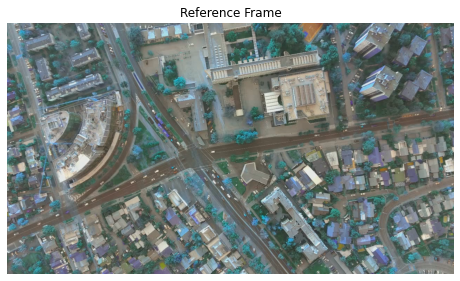

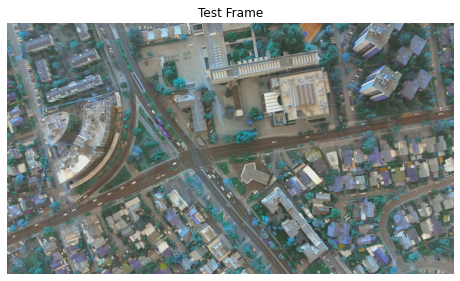

In [4]:
def show_image_with_caption(image, caption = None):
    plt.figure(figsize=(8, 6))
    plt.imshow(image)
    plt.title(caption)
    plt.axis('off')
    plt.show()

def extract_frame(video_path, frame_n):
  # Open the video file
  video_capture = cv2.VideoCapture(video_path)

  total_frames = int(video_capture.get(cv2.CAP_PROP_FRAME_COUNT))

  if total_frames >= frame_n and frame_n > 0:
    # Set the start frame
    video_capture.set(cv2.CAP_PROP_POS_FRAMES, frame_n)

    # Read the frame
    _, frame = video_capture.read()

    return frame, total_frames
  else:
    return None

def print_and_display_keypoints(keypoints, frame):
    # Draw keypoints on the frame
    frame_with_keypoints = cv2.drawKeypoints(frame, keypoints, None, color=(0, 255, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    # Convert the frame to RGB format for display with Matplotlib
    frame_rgb = cv2.cvtColor(frame_with_keypoints, cv2.COLOR_BGR2RGB)

    # Display the frame with keypoints
    plt.imshow(frame_rgb)
    plt.axis('off')
    plt.title("Características")
    plt.show()

reference_frame, total_frames = extract_frame(VIDEO_PATH, 1)
test_frame, _ = extract_frame(VIDEO_PATH, 100)

print(f"Total Frames = {total_frames}")
show_image_with_caption(reference_frame, "Reference Frame")
show_image_with_caption(test_frame, "Test Frame")

### Paso 3: Extraer Características

El algoritmo ORB es un método comúnmente utilizado para la detección de características y la extracción de descriptores combinando el algoritmo FAST y el descriptor BRIEF.

En concreto, se utiliza el método `detectAndCompute()` para extraer los ***Keypoints*** y los **Descriptores** asociados a cada imagen. Donde los Keypoints corresponden a las coordenadas de cada característica y los descriptores corresponden a una representación numérica que describe las características de una región o punto de interés en una imagen.

Los parámetros de interés en este método son:
#### Input
- `nfeatures`: Permite definir el número de características a extraer.
- `mask`: Permite definir una máscara sobre la cual se delimita la obtención de características.

#### Output
- `Keypoints`: arreglo de Coordenadas X Y de cada característica.
- `Descriptors`: arreglo de vectores Binarios 32bit, que representan el vecindario de cada característica.

A continuación extraemos las características de los dos fotogramas de prueba:

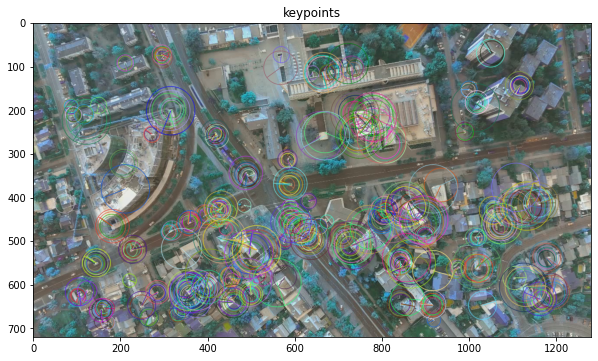

In [9]:
orb = cv2.ORB_create(nfeatures=NFEATURES)
keypoints1, descriptors1 = orb.detectAndCompute(reference_frame, mask = None)
keypoints2, descriptors2 = orb.detectAndCompute(test_frame, mask = None)

test = cv2.drawKeypoints(reference_frame, keypoints1, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.figure(figsize=figsize)
plt.imshow(test)
plt.title("keypoints")
plt.show()

### Paso 4: Emparejar Características
El siguiente desafío es identificar las características equivalentes de ambos fotogramas. Para esto, primero se utiliza el método BFMatcher (Brute-Force Matcher), el cual recorre el arreglo de descriptores de la imagen1 y calcula la distancia hamming de cada pareja de descriptores, sin usar ningún esquema de indexación. Donde aquellas características con menor distancia tienen un mayor número de probabilidades de ser la misma.

Una vez hecho esto es necesario seleccionar las características, utilizando la función `sorted()` se ordenan las parejas según su distancia de menor a mayor. Luego, para delimitar el margen de distancias de estas, extraemos un porcentaje al cual llamamos *feature rate*.

Por último, es necesario obtener los keypoints asociados a cada una de estas características.

Numero de Parejas detectadas: 1000
Numero de parejas a trabajar: 1000


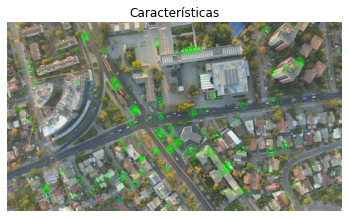

In [12]:
# Emparejar Caracteristicas
matcher = cv2.BFMatcher(cv2.NORM_HAMMING)
matches = matcher.match(descriptors1, descriptors2)


# Elegir Caracteristicas
feature_rate = 1
total_matches = len(matches)
work_matches = int(total_matches * feature_rate)  # la cantidad de caracteristicas con las que vamos a trabajar
matches = sorted(matches, key=lambda x: x.distance)[:work_matches]

print(f"Numero de Parejas detectadas: {total_matches}")
print(f"Numero de parejas a trabajar: {work_matches}")

# Obtener Keypoints de las características
src_keypoints = tuple(keypoints1[m.queryIdx] for m in matches)
dst_keypoints = tuple(keypoints2[m.trainIdx] for m in matches)

print_and_display_keypoints(dst_keypoints, reference_frame)

### Paso 5: Frame Stitching

Según el libro Computer Vision (Richard Szeliski), entendemos por Image Stitching el proceso necesario para sobreponer dos imagenes que representen un mismo cuadro. En este paso es necesario calcular la matriz que represente la transformación 2D afín entre las dos imagenes.

Para esto se utiliza el metodo `estimateAffinePartial2D()` de openCV, el cual toma las coordenadas de los pares de caracteristcias para estimar el desplazamiento, rotación y escalamiento entre las dos imagenes. Aplicando el Modelo lineal de **Ransak** para identificar cuales son las parejas que más se acercan al modelo y de esta manera generar una matriz de 2x3 que representa una transformación 2D con cuatro grados de livertad. 

[cos(theta)*s, -sin(theta)*s, tx;  
 sin(theta)*s,  cos(theta)*s, ty]

Donde theta es el ángulo de rotación, s es el factor de escalamiento y tx, ty son translaciones en los ejes x, y respectivamente.

Luego usando el metodo `warpAffine()` es posible aplicar la transformación de la matriz resultante sobre el frame comparado.



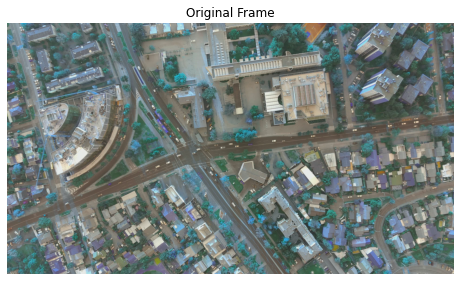

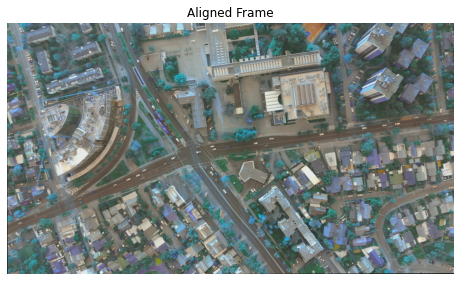

In [8]:
src_pts = np.float32([keypoints1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)


affine_matrix, _ = cv2.estimateAffinePartial2D(src_pts, dst_pts, confidence= 0.9, method=cv2.RANSAC)
aligned_image = cv2.warpAffine(test_frame, affine_matrix, (reference_frame.shape[1], reference_frame.shape[0]))

show_image_with_caption(reference_frame, "Original Frame")
show_image_with_caption(aligned_image, "Aligned Frame")

## Demostración Alineamiento Afín de Fotogramas ORB en Video

En el presente código es posible procesar todo el video y obtener uno alineado. Para observar el video resultante es necesario descargarlo en los archivos desde el costado.

In [5]:
def extract_affine_matrix(image1, image2):
  # Detectar Keypoints y descriptores para cada frame
  orb = cv2.ORB_create(nfeatures=NFEATURES)
  keypoints1, descriptors1 = orb.detectAndCompute(image1, mask=None)
  keypoints2, descriptors2 = orb.detectAndCompute(image2, mask=None)

  # Emparejar Caracteristicas
  matcher = cv2.BFMatcher(cv2.NORM_HAMMING)
  matches = matcher.match(descriptors1, descriptors2)

  # Elegir Caracteristicas
  feature_rate = 0.5
  num_matches = int(len(matches) * feature_rate)  # la cantidad de caracteristicas con las que vamos a trabajar
  matches = sorted(matches, key=lambda x: x.distance)[:num_matches]

  # Obtener Keypoints de las caracteristcias
  src_pts = np.float32([keypoints1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
  dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

  # Estimar una matriz de transformación Afín
  affine_matrix, _ = cv2.estimateAffinePartial2D(src_pts, dst_pts)

  return affine_matrix

def get_video_affine_transformations(input_path):
  # Open the video file for reading
  video_capture = cv2.VideoCapture(input_path)
  total_frames = int(video_capture.get(cv2.CAP_PROP_FRAME_COUNT))

  # Read the reference frame
  for i in range(1):
    ret, first_frame = video_capture.read()

  video_affine_transformations = []
  frame_count = 0
  while True:

    ret, frame = video_capture.read()
    if not ret:
      break

    # Extraer matriz afín
    affine_matrix = extract_affine_matrix(frame, first_frame)
    video_affine_transformations.append(affine_matrix)

    frame_count += 1
    if (frame_count % 100 == 0):
      print(f"Matrices listas {frame_count}/{total_frames}")


  # Release the video capture and writer objects
  video_capture.release()

  return  np.array(video_affine_transformations)

  
video_affine_transformations = get_video_affine_transformations(VIDEO_PATH)

def process_video(input_path, output_path):
  # Open the video file for reading
  video_capture = cv2.VideoCapture(input_path)

  # Get video properties
  fps = video_capture.get(cv2.CAP_PROP_FPS)
  width = int(video_capture.get(cv2.CAP_PROP_FRAME_WIDTH))
  height = int(video_capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
  total_frames = int(video_capture.get(cv2.CAP_PROP_FRAME_COUNT))
  
  # Create VideoWriter object to save the output video
  fourcc = cv2.VideoWriter_fourcc(*'mp4v')
  video_writer = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

  # Read the reference frame
  for i in range(1):
    ret, first_frame = video_capture.read()

  frame_count = 0
  while True:
    
    ret, frame = video_capture.read()
    if not ret:
      break

    # Process the frame
    frame_processed = cv2.warpAffine(frame, video_affine_transformations[frame_count], (first_frame.shape[1], first_frame.shape[0]))

    # Write the processed frame to the output video file
    video_writer.write(frame_processed)

    frame_count += 1
    if (frame_count % 100 == 0):
      print(f"Processed frame {frame_count}/{total_frames}")

  # Release the video capture and writer objects
  video_capture.release()
  video_writer.release()


# Example usage
output_video_path = VIDEO_PATH.replace(".mp4", "_estabilizado.mp4")

process_video(VIDEO_PATH, output_video_path)

Matrices listas 100/901
Matrices listas 200/901
Matrices listas 300/901
Matrices listas 400/901
Matrices listas 500/901
Matrices listas 600/901
Matrices listas 700/901
Matrices listas 800/901
Matrices listas 900/901
Processed frame 100/901
Processed frame 200/901
Processed frame 300/901
Processed frame 400/901
Processed frame 500/901
Processed frame 600/901
Processed frame 700/901
Processed frame 800/901
Processed frame 900/901


## Conclusiones

Si bien podemos observar una notoria mejora en el video resultante, al observar los gráficos de cada métrica con respecto a los fotogramas, notamos una falta de consistencia del método implementado.